<h1>Inporting Necessary Libraries and datasets</h1>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 5000)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import RobustScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge as krr
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

import optuna
from functools import partial

In [82]:
train, test = pd.read_csv('train.csv'), pd.read_csv('test.csv')

<h3>A Glimpse of the datasets</h3>

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
print(f'Train has {train.shape[0]} rows and {train.shape[1]} columns')
print(f'Test has {test.shape[0]} rows and {test.shape[1]} columns')

Train has 1460 rows and 81 columns
Test has 1459 rows and 80 columns


In [6]:
num_vars = pd.DataFrame(train.columns[train.dtypes != 'object'], columns=['vars']).T
obj_vars = pd.DataFrame(train.columns[train.dtypes == 'object'], columns=['vars']).T

EDA

1. 종속변수 확인

SalePrice'skew: 1.8828757597682129
SalePrice'kurt: 6.536281860064529


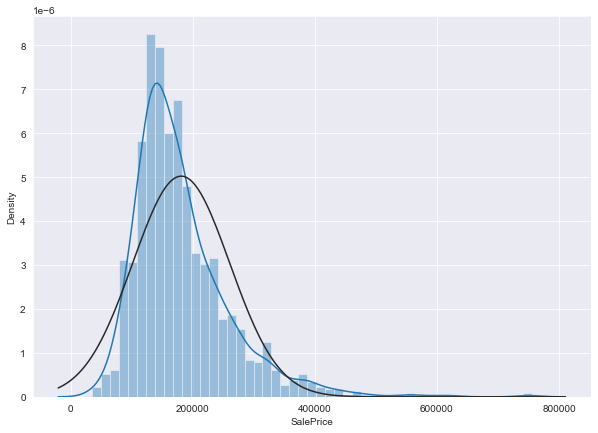

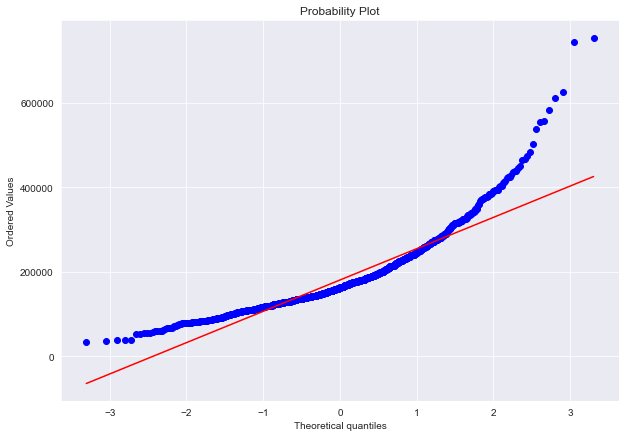

In [7]:
print(f"SalePrice'skew: {train.SalePrice.skew()}")
print(f"SalePrice'kurt: {train.SalePrice.kurt()}")
plt.subplots(figsize=(10, 7))
sns.distplot(train.SalePrice, fit=norm)
plt.show()
plt.subplots(figsize=(10, 7))
probplot(train.SalePrice, plot=plt)
plt.show()

결론: 종속변수의 정규성이 위배된다. 나중에 변환이 필요하다.

1. 변수 타입 확인 (명목, 순위 변수 확인)

In [8]:
nominal_vars = [
    'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
    'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 
    'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'
]

In [9]:
order_vars = [
    'MSSubClass', 'Street', 'Alley', 'LotShape', 'Utilities', 'LandSlope', 
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'
]

2. 연속형 변수의 기초 통계량 확인

In [10]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


결론: 최소값이 0인 변수들이 다수 존재한다. 혹시 모르니 이 변수들을 기억해둔다.

3. 결측치 확인

In [11]:
all_data = pd.concat((train, test)).drop(['SalePrice'], axis=1)

missing_count = all_data.isnull().sum().sort_values(ascending=False)
missing_percent = missing_count / all_data.shape[0]
missing_table = pd.DataFrame({'count': missing_count, 'percent': missing_percent})
missing_table = missing_table[missing_table.percent > 0]

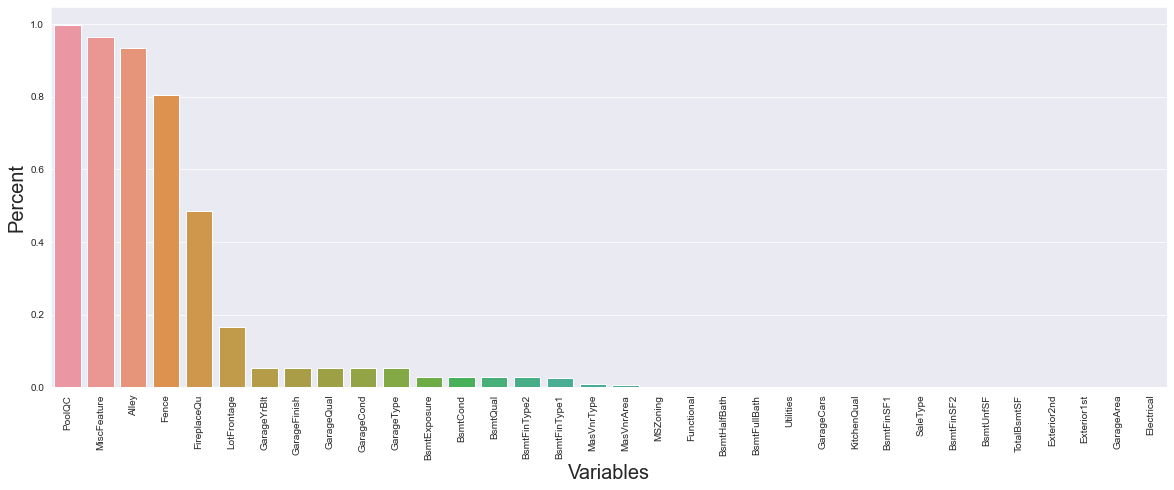

In [12]:
f, ax = plt.subplots(figsize=(20, 7))
sns.barplot(x=missing_table.index, y=missing_table.percent)
plt.xlabel('Variables', fontsize=20)
plt.ylabel('Percent', fontsize=20)
plt.xticks(rotation='90')
plt.show()

결론: 결측치가 존재하는 변수가 많다. 나중에 결측치 처리를 해줘야 한다.

5. 상관분석, 히트맵, 산점도, 박스플롯

<AxesSubplot:>

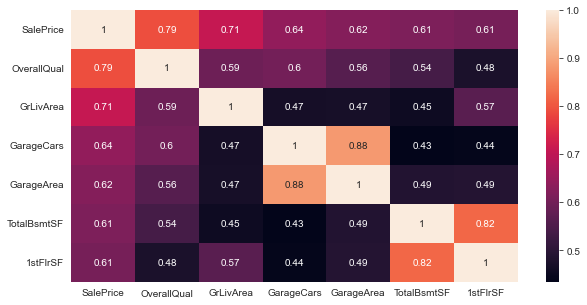

In [13]:
plt.subplots(figsize=(10, 5))
high_corr = train.corr().SalePrice.sort_values(ascending=False)[:7].index
sns.heatmap(train[high_corr].corr(), annot=True)

상관분석 결론: 
1) 종속변수와 상대적으로 높은 선형 상관성을 갖는 변수들은 OverallOual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF이다.

2) GarageCars - GarageArea, 1stFlrSF - TotalBsmtSF의 선형 상관성이 높다. -> 다중 공선성을 유발한다. 나중에 회귀모형을 작성할 땐 Lasso, Ridge 같은 정규화 방식이 필요하다.

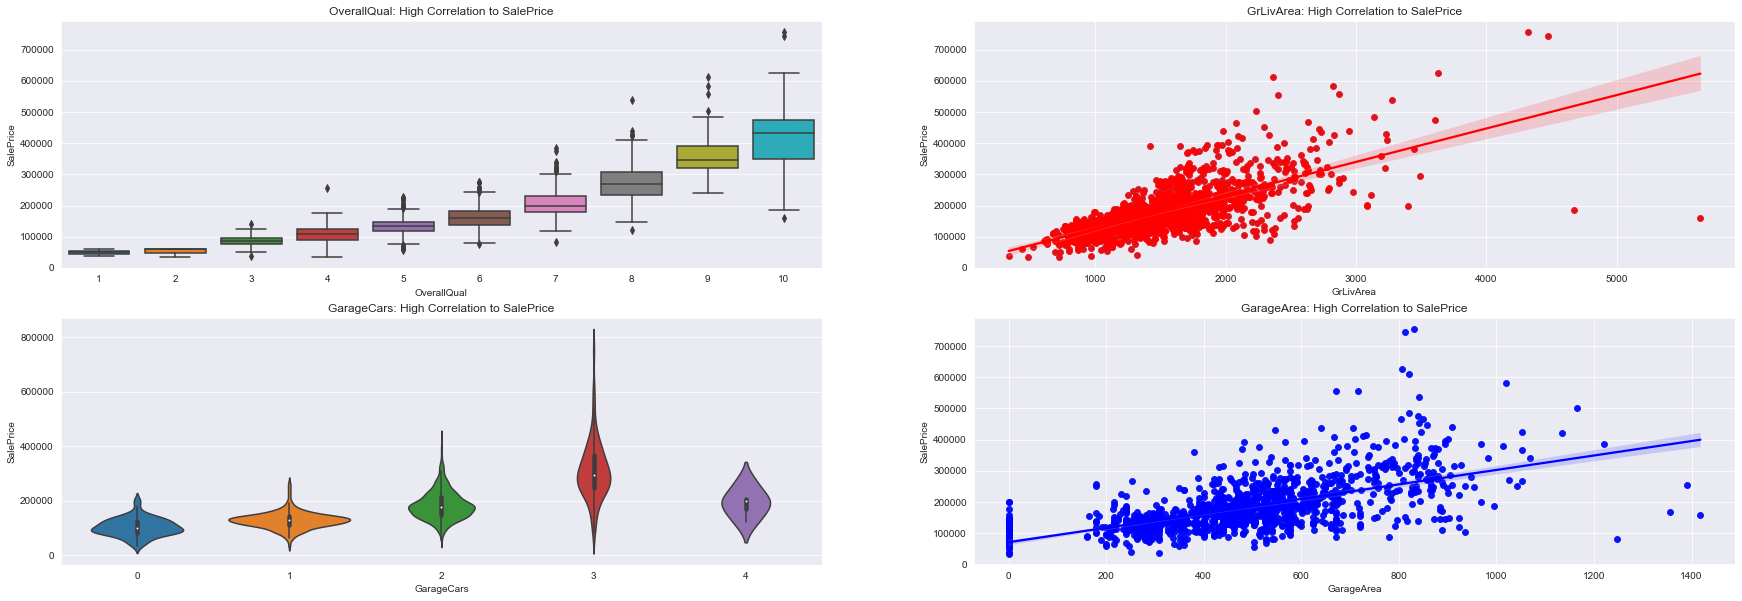

In [14]:
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(30, 10))
f1 = sns.boxplot(x=train.OverallQual, y=train.SalePrice, ax=ax1[0])
f1.set_title('OverallQual: High Correlation to SalePrice')

f2 = sns.scatterplot(x=train.GrLivArea, y=train.SalePrice, ax=ax1[1])
sns.regplot(x=train.GrLivArea, y=train.SalePrice, color='r', ax=ax1[1])
f2.set_title('GrLivArea: High Correlation to SalePrice')

f2 = sns.violinplot(x=train.GarageCars, y=train.SalePrice, ax=ax2[0])
f2.set_title('GarageCars: High Correlation to SalePrice')

f2 = sns.scatterplot(x=train.GarageArea, y=train.SalePrice, ax=ax2[1])
sns.regplot(x=train.GarageArea, y=train.SalePrice, color='b', ax=ax2[1])
f2.set_title('GarageArea: High Correlation to SalePrice')
plt.show()

산점도, 박스플롯 결론: 
1) 앞서 살펴본 상관성이 강한 변수들과 종속변수의 관계를 시각화할 수 있다.

2) GrLivArea 산점도에서 2개의 이상치를 발견할 수 있다.

In [15]:
def chart_var(var):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    sns.distplot(train[var], fit=norm, ax=ax1)
    sns.residplot(x=train[var], y=train.SalePrice, ax=ax2)
    plt.show()
    probplot(train[var], plot=plt);

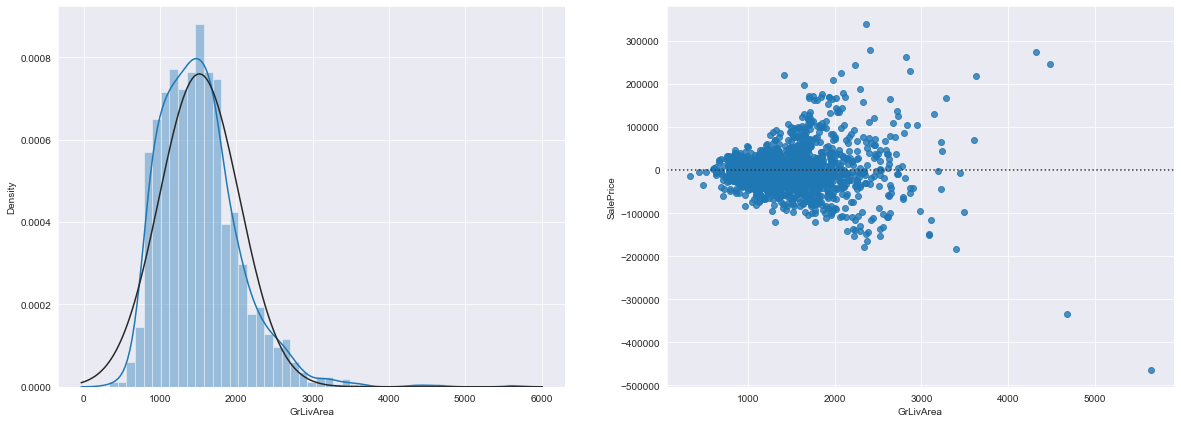

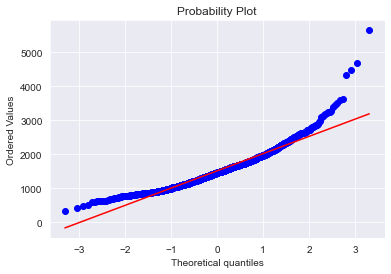

In [16]:
chart_var('GrLivArea')

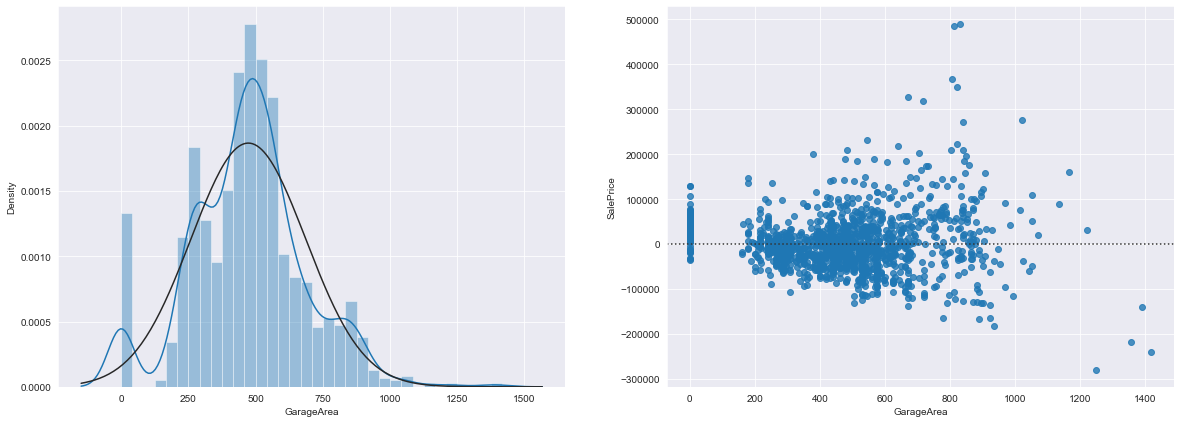

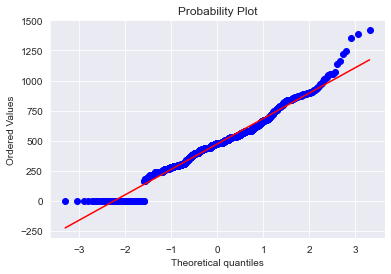

In [17]:
chart_var('GarageArea')

히스토그램, 잔차도, qq플롯 결론:
1) 강한 상관성을 띄는 몇몇 변수들만 확인해보았다.

2) 히스토그램이 한쪽으로 치우져서 있음 -> 변환 필요

3) 잔차도의 포인트들이 패턴을 형성 -> 변환 필요.

4) qq플롯에서 포인트가 기준선에서 벗어남 -> 변환 필요.

왜도, 첨도 확인

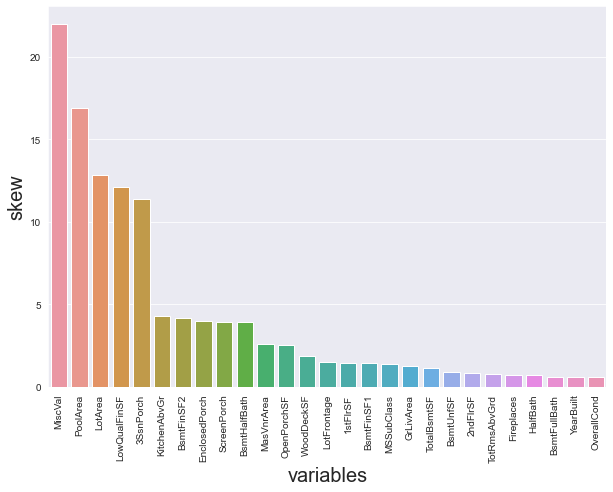

In [18]:
skews = abs(all_data.skew()).sort_values(ascending=False)
kurts = abs(all_data.kurt()).sort_values(ascending=False)
skew_kurt_table = pd.DataFrame((skews, kurts), index=['skew', 'kurt']).T
skew_kurt_table = skew_kurt_table[skew_kurt_table['skew'] > 0.5]

f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x=skew_kurt_table.index, y=skew_kurt_table['skew'])
plt.xticks(rotation='90')
plt.xlabel('variables', size=20)
plt.ylabel('skew', size=20)
plt.show()

결론: 
1) 왜도가 0.5보다 큰 변수들을 추출해서 시각화해본다.

2) 정규성을 만족하지 못하는 변수들이 많다. 나중에 일괄적으로 변환 작업이 필요하다.

전처리

1. Id 제거

In [83]:
train_id, test_id = train.Id, test.Id
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

2. 이상치 제거

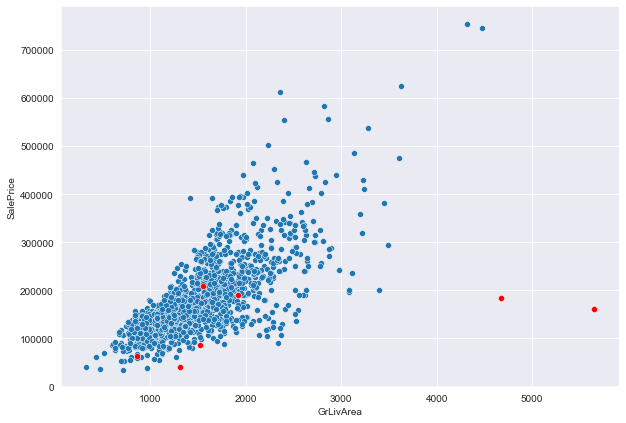

In [84]:
plt.subplots(figsize=(10, 7))
sns.scatterplot(x=train.GrLivArea, y=train.SalePrice)
outlier_idx = train.GrLivArea.sort_values(ascending=False)[:2].index
outlier_idx = list(outlier_idx.values) + [30, 88, 462, 631, 1322]
sns.scatterplot(x=train.iloc[outlier_idx].GrLivArea, y=train.iloc[outlier_idx].SalePrice, color='r');

In [85]:
train.drop(outlier_idx, axis=0, inplace=True)
train = train.reset_index(drop=True)

3. 훈련, 테스트 데이터 병합, 종속 변수 분리

In [86]:
train_size = train.shape[0]
y_train = train.SalePrice
all_data = pd.concat((train, test)).drop(['SalePrice'], axis=1)

4. 결측치 처리

In [23]:
missing_vars = all_data.columns[all_data.isnull().sum() > 0]
missing_vars

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

case 1: 다른 변수들을 통해 유추할 수 있는 결측치.

In [24]:
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

case2: 특정 값으로 대체할 수 있는 결측치

1) 순위형 변수들은 결측치가 Na, Pool 등 부정적 의미를 가질 수 있는데 해당 값이 없는 경우 이 값으로 대체 가능.

2) 명목형 변수들은 최빈값으로 대체 가능

3) 연속형 변수들은 0, 중심경향치 등으로 대체 가능.

In [25]:
# 1)
for c in ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
          'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
          'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'KitchenQual']:
    all_data[c] = all_data[c].fillna('None')

# 2)
for c in ['Exterior1st', 'Exterior2nd', 'Electrical', 'BsmtFullBath', 'Utilities', 
          'SaleType', 'Functional']:
    all_data[c] = all_data[c].fillna(all_data[c].mode()[0])

# 3)
for c in ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
         'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']:
    all_data[c] = all_data[c].fillna(0)

In [26]:
all_data.isnull().sum().sum()

0

5. 파생변수 생성

In [27]:
all_data['TotalSF'] = (all_data['TotalBsmtSF']  + all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']
all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1']  + all_data['BsmtFinSF2'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF'])
all_data['Haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['Hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['Hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)                                             

6. 변수변환

In [28]:
all_data[nominal_vars] = all_data[nominal_vars].astype('str')
all_data[order_vars] = all_data[order_vars].astype('str')
num_vars = all_data.columns[all_data.dtypes != 'object']

In [29]:
# 순서형 변수 라벨 인코딩
le = LabelEncoder()
for c in order_vars:
    all_data[c] = le.fit_transform(all_data[c])

In [30]:
# 연속형 변수 박스콕스 변환
for c in num_vars:
    if abs(all_data[c].skew()) > 0.5:
        all_data[c] = boxcox1p(all_data[c], .15)

In [31]:
abs(all_data.skew()).sort_values(ascending=False)[:20]

Utilities       53.962950
PoolQC          21.210215
PoolArea        15.753969
Haspool         15.489285
Street          15.489285
3SsnPorch        8.918309
LowQualFinSF     8.860177
Hasbsmt          5.824396
MiscVal          5.592599
LandSlope        4.971053
TotalBsmtSF      3.985538
Hasgarage        3.952322
GarageYrBlt      3.936482
BsmtHalfBath     3.784738
KitchenAbvGr     3.695399
GarageCond       3.610423
GarageQual       3.076015
BsmtFinType2     3.049361
PavedDrive       2.991762
ScreenPorch      2.975224
dtype: float64

In [32]:
all_data.drop(['Utilities', 'PoolQC', 'PoolArea', 'Street'], axis=1, inplace=True)

In [33]:
# 명목형 변수 원핫 인코딩
all_data = pd.get_dummies(all_data)
all_data.head()

,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,Haspool,Has2ndfloor,Hasgarage,Hasbsmt,Hasfireplace,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,5.831328,19.212182,1,3,0,7,2.055642,14.187527,2003,8.059126,2,4,2,4,3,2,11.170327,6,0.0,7.483296,11.692623,0,11.692623,11.686189,0.0,13.698888,0.730463,0.000000,2,0.730463,3,0.730463,2,2.602594,0.000000,3,14.187527,2,2.0,548.0,5,5,2,0.000000,5.714669,0.000000,0.0,0.0,4,0.0,2,2008,14.976591,4006,14.781997,3.5,5.714669,0.0,1,0.

In [57]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = overfit_reducer(all_data)

all_data.drop(overfitted_features, axis=1, inplace=True)

7. 훈련, 테스트 데이터 분할

In [58]:
X_train, X_test = all_data.iloc[:train_size, :], all_data.iloc[train_size:, :]

In [59]:
X_train.shape, X_test.shape, y_train.shape

((1453, 223), (1459, 223), (1453,))

모델링

1. 교차검증 점수 확인용 함수

In [37]:
def rmsle_cv(model):
    return np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error',
                   cv=5, verbose=0, n_jobs=-1))

2. 그리드서치 (Lasso, ElasticNet, KernelRidge, SVR)

In [38]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso())
])
model_elasticNet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(max_iter=5000))
])
model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr())
])

model_svr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', SVR())
])

grid_param_lasso = {
    'model__alpha': 0.0001 * np.arange(1, 100)
}
grid_param_elasticNet = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__l1_ratio': 0.001 * np.arange(1, 10)
}
grid_param_krr = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__degree': [1, 2, 3],
    'model__kernel': ['polynomial'],
    'model__coef0': [2.5]
}
grid_param_svr = {
    'model__C': [5, 10, 20],
    'model__gamma': [.0001, .0002, .0003, .0004, .0005, .0006, .0007, .0008, .0009, .001],
    'model__epsilon': [.001, .002, .003, .004, .005, .006, .007, .008, .009, .01]
}

In [39]:
# search_lasso = GridSearchCV(model_lasso, grid_param_lasso, scoring='neg_mean_squared_error',
#                            cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
# search_lasso.best_params_

In [40]:
# search_elasticNet = GridSearchCV(model_elasticNet, grid_param_elasticNet, scoring='neg_mean_squared_error',
#                            cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
# search_elasticNet.best_params_

In [41]:
# search_krr = GridSearchCV(model_krr, grid_param_krr, scoring='neg_mean_squared_error',
#                            cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
# search_krr.best_params_

In [42]:
search_svr = GridSearchCV(model_svr, grid_param_svr, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
search_svr.best_params_

KeyboardInterrupt: 

In [61]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(alpha=0.0004))
])
model_elasticNet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(alpha=0.008, l1_ratio=0.009000000000000001))
])
model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr(alpha=0.0099,
                        kernel='polynomial',
                        degree=1,
                        coef0=2.5))
])
model_svr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', SVR(C=20,gamma=0.0004, epsilon=0.01))
])

In [62]:
model_xgbr = XGBRegressor(colsample_bytree=0.4, learning_rate=0.00898718134841855, max_depth=8, 
                             n_estimators=2200, reg_alpha=0.036142628805195254, reg_lambda=0.03188665185506858,
                             subsample=0.6, random_state =42)

In [63]:
model_gbr = gbr(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)

In [64]:
model_lgbm = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [65]:
stack_gen = StackingCVRegressor(regressors=(model_lgbm, model_lasso, model_elasticNet, model_krr, model_gbr, model_svr),
                               meta_regressor=model_xgbr,
                               use_features_in_secondary=True)

In [66]:
models = [
    model_lasso, model_elasticNet, model_krr, model_svr, model_gbr, model_xgbr, model_lgbm
]
cross_score = {
    'Lasso': 0,
    'ElasticNet': 0,
    'Kernel Ridge': 0,
    'SVR': 0,
    'GradientBoosting': 0,
    'XGBoost': 0,
    'LightGBM': 0,
}

for idx, model in enumerate(models):
    cross_score[list(cross_score.keys())[idx]] = rmsle_cv(model).mean()

In [49]:
cross_score

{'Lasso': 0.10672194755209075,
 'ElasticNet': 0.10774934599317128,
 'Kernel Ridge': 0.10925572232658647,
 'SVR': 0.1076983387101621,
 'GradientBoosting': 0.11213336709436343,
 'XGBoost': 0.10889209601771188,
 'LightGBM': 0.11073349305246125}

In [67]:
cross_score

{'Lasso': 0.10672194755209075,
 'ElasticNet': 0.10774759371580434,
 'Kernel Ridge': 0.10929253204329988,
 'SVR': 0.10770686872422996,
 'GradientBoosting': 0.11112192734676221,
 'XGBoost': 0.10903877109337812,
 'LightGBM': 0.11073349305246125}

In [68]:
for model in models:
    model = model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [69]:
stack_gen = stack_gen.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [79]:
def blend(X):
    return ((0.10 * model_lasso.predict(X)) + \
            (0.10 * model_elasticNet.predict(X)) + \
            (0.10 * model_krr.predict(X)) + \
            (0.10 * model_xgbr.predict(X)) + \
            (0.10 * model_lgbm.predict(X)) + \
            (0.10 * model_svr.predict(X)) + \
            (0.40 * stack_gen.predict(np.array(X))))

In [80]:
np.sqrt(mse(y_train, blend(X_train)))

0.044330582370548155

In [81]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = score = np.expm1(blend(X_test))
sub.to_csv('submission.csv',index=False)

In [ ]:
cross_score